# Creating and Backtesting Mean-Reversion Strategies (Bollinger Bands)

## Getting the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")
#!pip install pandas_datareader
import pandas_datareader.data as web

In [2]:
start= pd.to_datetime('2016-01-01')
end= pd.to_datetime('2021-03-01')
data = web.DataReader('ETH-USD','yahoo',start, end)
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,0.954822,0.931442,0.933712,0.948024,206062.0,0.948024
2016-01-02,0.969637,0.936560,0.947401,0.937124,255504.0,0.937124
2016-01-03,0.991362,0.934313,0.938430,0.971905,407632.0,0.971905
2016-01-04,0.976438,0.929835,0.972045,0.954480,346245.0,0.954480
2016-01-05,0.970597,0.946543,0.953147,0.950176,219833.0,0.950176


In [3]:
data.drop(['High','Low','Open','Volume','Adj Close'], axis=1,inplace=True)

In [4]:
data.to_csv("ETH_close.csv")

In [5]:
data = pd.read_csv("ETH_close.csv", parse_dates = [0], index_col = 0)

In [6]:
data

,Close
Date,
2016-01-01,0.948024
2016-01-02,0.937124
2016-01-03,0.971905
2016-01-04,0.954480
2016-01-05,0.950176
...,...
2021-02-26,1446.033691
2021-02-27,1459.973145
2021-02-28,1416.048950


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1884 entries, 2016-01-01 to 2021-03-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1884 non-null   float64
dtypes: float64(1)
memory usage: 29.4 KB


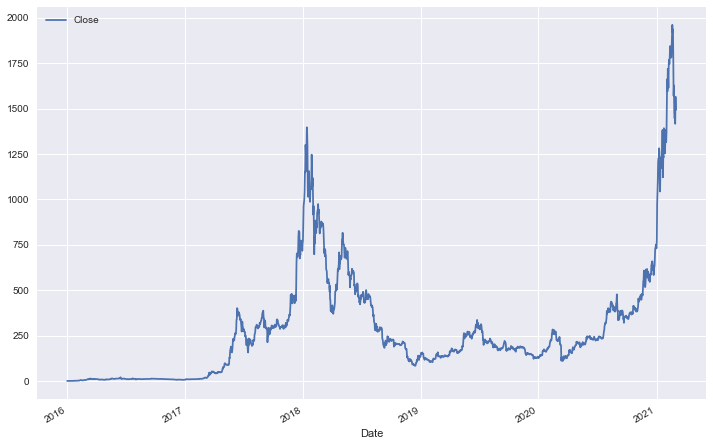

In [8]:
data.plot(figsize = (12, 8))
plt.show()

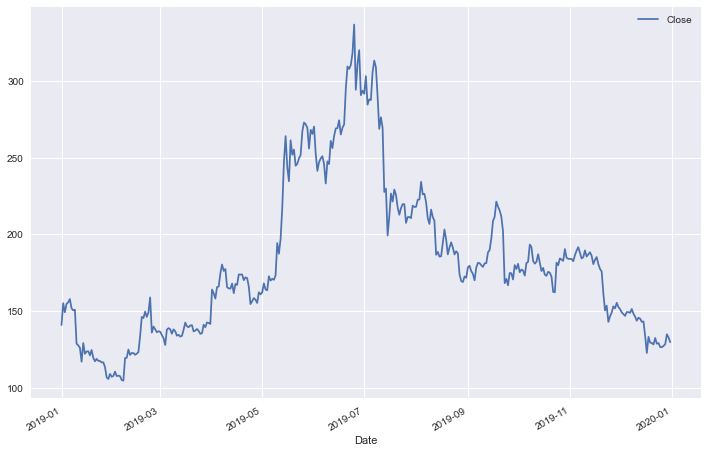

In [9]:
data.loc["2019"].plot(figsize = (12, 8))
plt.show()

In [10]:
data["returns"] = np.log(data.div(data.shift(1)))

In [11]:
data

,Close,returns
Date,,
2016-01-01,0.948024,NaN
2016-01-02,0.937124,-0.011564
2016-01-03,0.971905,0.036442
2016-01-04,0.954480,-0.018091
2016-01-05,0.950176,-0.004519
...,...,...
2021-02-26,1446.033691,-0.020311
2021-02-27,1459.973145,0.009594
2021-02-28,1416.048950,-0.030547


## Defining a Mean-Reversion Strategy (Bollinger Bands) (Part 1)

__Mean Reversion__: Financial Instruments are from time to time overbought / oversold and revert back to mean prices. 

__Bollinger Bands__: Consists of a SMA (e.g. 20) and Upper and Lower Bands +- (2) Std Dev away from SMA.

In [12]:
SMA = 20
dev = 2

In [13]:
data["SMA"] = data["Close"].rolling(SMA).mean()

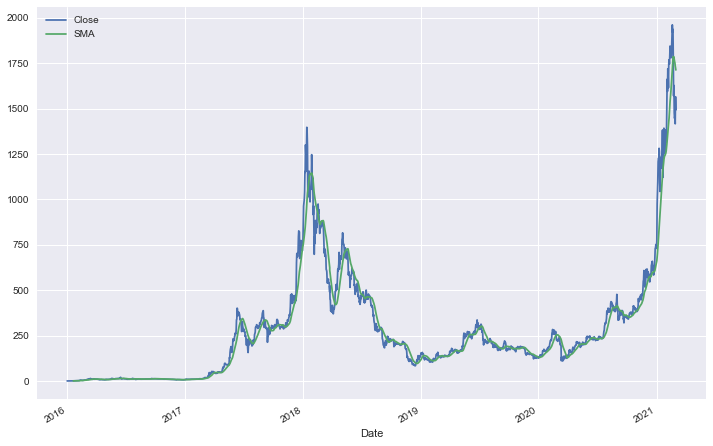

In [14]:
data[["Close", "SMA"]].plot(figsize = (12, 8))
plt.show()

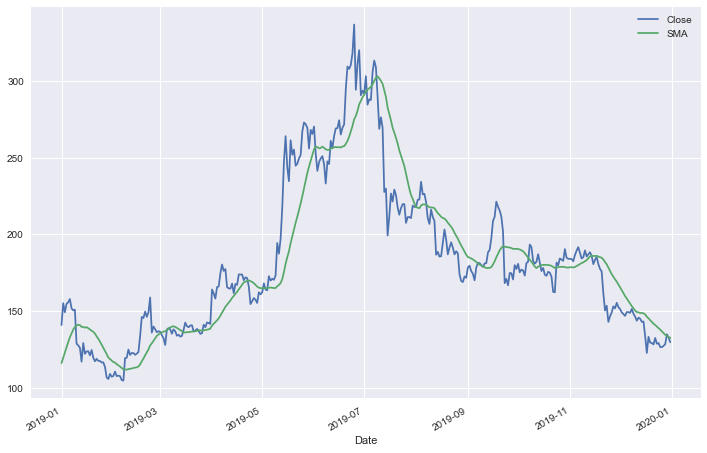

In [15]:
data.loc["2019", ["Close", "SMA"]].plot(figsize = (12, 8))
plt.show()

In [16]:
data["Close"].rolling(SMA).std()

Date
2016-01-01           NaN
2016-01-02           NaN
2016-01-03           NaN
2016-01-04           NaN
2016-01-05           NaN
                 ...    
2021-02-26    145.898136
2021-02-27    157.570652
2021-02-28    174.524068
2021-03-01    178.370193
2021-03-02    185.645791
Name: Close, Length: 1884, dtype: float64

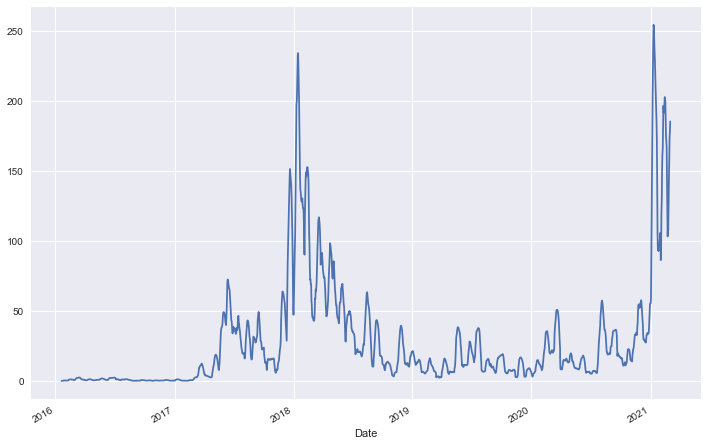

In [17]:
data["Close"].rolling(SMA).std().plot(figsize = (12, 8 ))
plt.show()

In [18]:
data["Lower"] = data["SMA"] - data["Close"].rolling(SMA).std() * dev # Lower Band -2 Std Dev

In [19]:
data["Upper"] = data["SMA"] + data["Close"].rolling(SMA).std() * dev # Upper Band -2 Std Dev

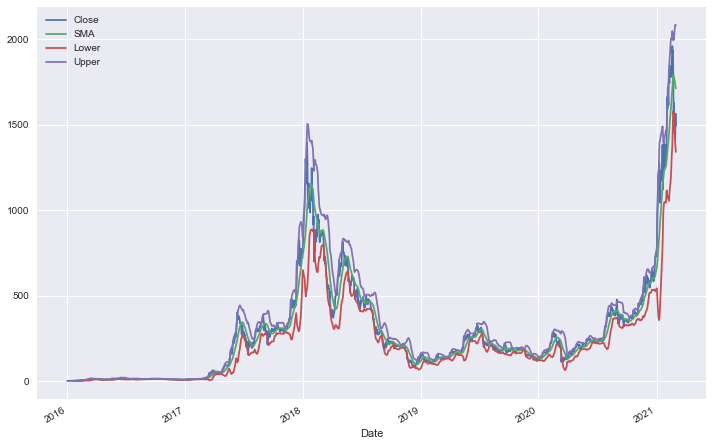

In [20]:
data.drop(columns = "returns").plot(figsize = (12, 8))
plt.show()

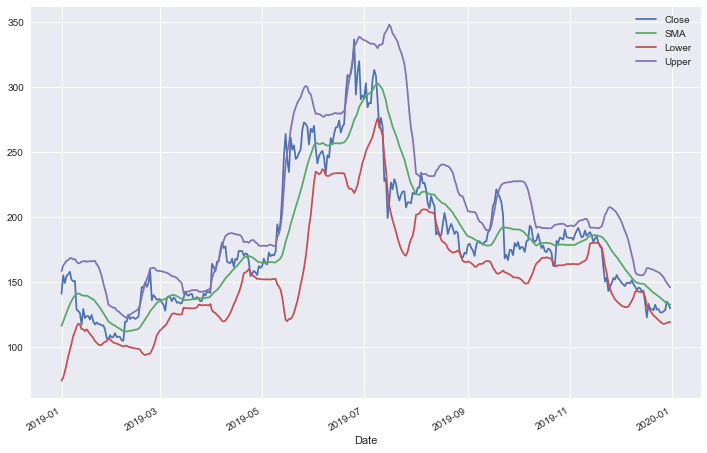

In [21]:
data.drop(columns = "returns").loc["2019"].plot(figsize = (12, 8))
plt.show()

In [22]:
data.dropna(inplace = True)

## Defining a Mean-Reversion Strategy (Bollinger Bands) (Part 2)

In [23]:
data

,Close,returns,SMA,Lower,Upper
Date,,,,,
2016-01-20,1.531820,0.110632,1.111507,0.742638,1.480376
2016-01-21,1.553570,0.014099,1.141784,0.732249,1.551319
2016-01-22,1.501270,-0.034244,1.169991,0.742490,1.597492
2016-01-23,1.972670,0.273076,1.220030,0.672677,1.767382
2016-01-24,2.141200,0.081979,1.279366,0.609614,1.949118
...,...,...,...,...,...
2021-02-26,1446.033691,-0.020311,1759.111176,1467.314903,2050.907448
2021-02-27,1459.973145,0.009594,1751.398444,1436.257140,2066.539747
2021-02-28,1416.048950,-0.030547,1734.870050,1385.821913,2083.918187


In [24]:
data["distance"] = data.Close - data.SMA # helper Column

In [25]:
data["position"] = np.where(data.Close < data.Lower, 1, np.nan) # 1. oversold -> go long

In [26]:
data["position"] = np.where(data.Close > data.Upper, -1, data["position"]) # 2. overbought -> go short

In [27]:
data.tail()

,Close,returns,SMA,Lower,Upper,distance,position
Date,,,,,,,
2021-02-26,1446.033691,-0.020311,1759.111176,1467.314903,2050.907448,-313.077484,1.0
2021-02-27,1459.973145,0.009594,1751.398444,1436.257140,2066.539747,-291.425299,NaN
2021-02-28,1416.048950,-0.030547,1734.870050,1385.821913,2083.918187,-318.821100,NaN
2021-03-01,1564.707642,0.099828,1724.703680,1367.963295,2081.444066,-159.996039,NaN
2021-03-02,1492.608765,-0.047174,1712.121948,1340.830366,2083.413531,-219.513184,NaN


In [28]:
# 3. crossing SMA ("Middle Band") -> go neutral
data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data["position"])

In [29]:
data

,Close,returns,SMA,Lower,Upper,distance,position
Date,,,,,,,
2016-01-20,1.531820,0.110632,1.111507,0.742638,1.480376,0.420313,-1.0
2016-01-21,1.553570,0.014099,1.141784,0.732249,1.551319,0.411786,-1.0
2016-01-22,1.501270,-0.034244,1.169991,0.742490,1.597492,0.331279,NaN
2016-01-23,1.972670,0.273076,1.220030,0.672677,1.767382,0.752640,-1.0
2016-01-24,2.141200,0.081979,1.279366,0.609614,1.949118,0.861834,-1.0
...,...,...,...,...,...,...,...
2021-02-26,1446.033691,-0.020311,1759.111176,1467.314903,2050.907448,-313.077484,1.0
2021-02-27,1459.973145,0.009594,1751.398444,1436.257140,2066.539747,-291.425299,NaN
2021-02-28,1416.048950,-0.030547,1734.870050,1385.821913,2083.918187,-318.821100,NaN


In [30]:
data["position"] = data.position.ffill().fillna(0) # where 1-3 isn´t applicable -> hold previous position

In [31]:
data.position.value_counts()

-1.0    756
 0.0    656
 1.0    453
Name: position, dtype: int64

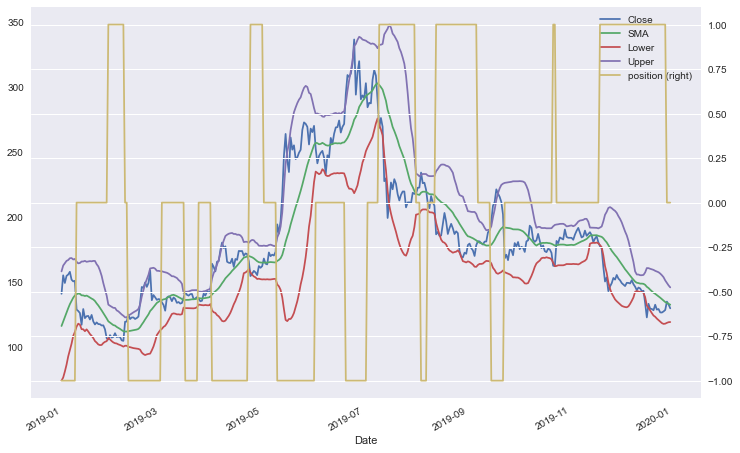

In [32]:
data.drop(columns = ["returns", "distance"]).loc["2019"].plot(figsize = (12, 8), secondary_y = "position")
plt.show()

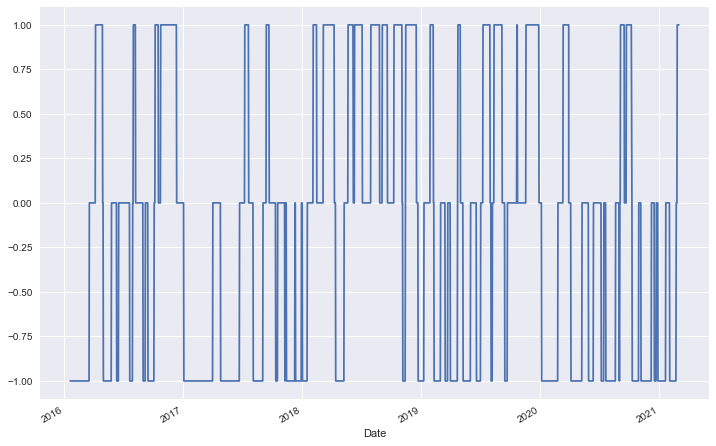

In [33]:
data.position.plot(figsize = (12, 8))
plt.show()

## Vectorized Strategy Backtesting

In [34]:
data

,Close,returns,SMA,Lower,Upper,distance,position
Date,,,,,,,
2016-01-20,1.531820,0.110632,1.111507,0.742638,1.480376,0.420313,-1.0
2016-01-21,1.553570,0.014099,1.141784,0.732249,1.551319,0.411786,-1.0
2016-01-22,1.501270,-0.034244,1.169991,0.742490,1.597492,0.331279,-1.0
2016-01-23,1.972670,0.273076,1.220030,0.672677,1.767382,0.752640,-1.0
2016-01-24,2.141200,0.081979,1.279366,0.609614,1.949118,0.861834,-1.0
...,...,...,...,...,...,...,...
2021-02-26,1446.033691,-0.020311,1759.111176,1467.314903,2050.907448,-313.077484,1.0
2021-02-27,1459.973145,0.009594,1751.398444,1436.257140,2066.539747,-291.425299,1.0
2021-02-28,1416.048950,-0.030547,1734.870050,1385.821913,2083.918187,-318.821100,1.0


In [35]:
data["strategy"] = data.position.shift(1) * data["returns"]

In [36]:
data.dropna(inplace = True)

In [37]:
data

,Close,returns,SMA,Lower,Upper,distance,position,strategy
Date,,,,,,,,
2016-01-21,1.553570,0.014099,1.141784,0.732249,1.551319,0.411786,-1.0,-0.014099
2016-01-22,1.501270,-0.034244,1.169991,0.742490,1.597492,0.331279,-1.0,0.034244
2016-01-23,1.972670,0.273076,1.220030,0.672677,1.767382,0.752640,-1.0,-0.273076
2016-01-24,2.141200,0.081979,1.279366,0.609614,1.949118,0.861834,-1.0,-0.081979
2016-01-25,2.499270,0.154632,1.356820,0.511958,2.201683,1.142450,-1.0,-0.154632
...,...,...,...,...,...,...,...,...
2021-02-26,1446.033691,-0.020311,1759.111176,1467.314903,2050.907448,-313.077484,1.0,-0.020311
2021-02-27,1459.973145,0.009594,1751.398444,1436.257140,2066.539747,-291.425299,1.0,0.009594
2021-02-28,1416.048950,-0.030547,1734.870050,1385.821913,2083.918187,-318.821100,1.0,-0.030547


In [38]:
data["creturns"] = data["returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)

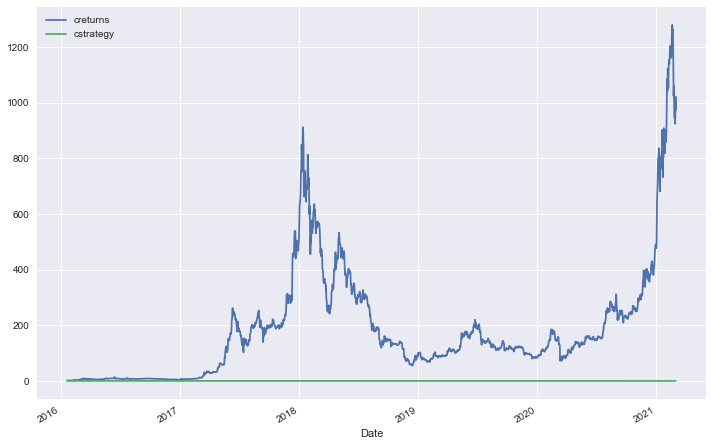

In [39]:
data[["creturns", "cstrategy"]].plot(figsize = (12 , 8))
plt.show()

In [40]:
data

,Close,returns,SMA,Lower,Upper,distance,position,strategy,creturns,cstrategy
Date,,,,,,,,,,
2016-01-21,1.553570,0.014099,1.141784,0.732249,1.551319,0.411786,-1.0,-0.014099,1.014199,0.986000
2016-01-22,1.501270,-0.034244,1.169991,0.742490,1.597492,0.331279,-1.0,0.034244,0.980056,1.020349
2016-01-23,1.972670,0.273076,1.220030,0.672677,1.767382,0.752640,-1.0,-0.273076,1.287795,0.776521
2016-01-24,2.141200,0.081979,1.279366,0.609614,1.949118,0.861834,-1.0,-0.081979,1.397814,0.715403
2016-01-25,2.499270,0.154632,1.356820,0.511958,2.201683,1.142450,-1.0,-0.154632,1.631569,0.612907
...,...,...,...,...,...,...,...,...,...,...
2021-02-26,1446.033691,-0.020311,1759.111176,1467.314903,2050.907448,-313.077484,1.0,-0.020311,943.997099,0.000678
2021-02-27,1459.973145,0.009594,1751.398444,1436.257140,2066.539747,-291.425299,1.0,0.009594,953.097027,0.000685
2021-02-28,1416.048950,-0.030547,1734.870050,1385.821913,2083.918187,-318.821100,1.0,-0.030547,924.422514,0.000664


In [41]:
ptc = 0.00007

In [42]:
data["trades"] = data.position.diff().fillna(0).abs()

In [43]:
data

,Close,returns,SMA,Lower,Upper,distance,position,strategy,creturns,cstrategy,trades
Date,,,,,,,,,,,
2016-01-21,1.553570,0.014099,1.141784,0.732249,1.551319,0.411786,-1.0,-0.014099,1.014199,0.986000,0.0
2016-01-22,1.501270,-0.034244,1.169991,0.742490,1.597492,0.331279,-1.0,0.034244,0.980056,1.020349,0.0
2016-01-23,1.972670,0.273076,1.220030,0.672677,1.767382,0.752640,-1.0,-0.273076,1.287795,0.776521,0.0
2016-01-24,2.141200,0.081979,1.279366,0.609614,1.949118,0.861834,-1.0,-0.081979,1.397814,0.715403,0.0
2016-01-25,2.499270,0.154632,1.356820,0.511958,2.201683,1.142450,-1.0,-0.154632,1.631569,0.612907,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-26,1446.033691,-0.020311,1759.111176,1467.314903,2050.907448,-313.077484,1.0,-0.020311,943.997099,0.000678,0.0
2021-02-27,1459.973145,0.009594,1751.398444,1436.257140,2066.539747,-291.425299,1.0,0.009594,953.097027,0.000685,0.0
2021-02-28,1416.048950,-0.030547,1734.870050,1385.821913,2083.918187,-318.821100,1.0,-0.030547,924.422514,0.000664,0.0


In [44]:
data.trades.value_counts()

0.0    1748
1.0     116
Name: trades, dtype: int64

In [45]:
data["strategy_net"] = data.strategy - data.trades * ptc

In [46]:
data["cstrategy_net"] = data.strategy_net.cumsum().apply(np.exp)

In [47]:
data

,Close,returns,SMA,Lower,Upper,distance,position,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net
Date,,,,,,,,,,,,,
2016-01-21,1.553570,0.014099,1.141784,0.732249,1.551319,0.411786,-1.0,-0.014099,1.014199,0.986000,0.0,-0.014099,0.986000
2016-01-22,1.501270,-0.034244,1.169991,0.742490,1.597492,0.331279,-1.0,0.034244,0.980056,1.020349,0.0,0.034244,1.020349
2016-01-23,1.972670,0.273076,1.220030,0.672677,1.767382,0.752640,-1.0,-0.273076,1.287795,0.776521,0.0,-0.273076,0.776521
2016-01-24,2.141200,0.081979,1.279366,0.609614,1.949118,0.861834,-1.0,-0.081979,1.397814,0.715403,0.0,-0.081979,0.715403
2016-01-25,2.499270,0.154632,1.356820,0.511958,2.201683,1.142450,-1.0,-0.154632,1.631569,0.612907,0.0,-0.154632,0.612907
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-26,1446.033691,-0.020311,1759.111176,1467.314903,2050.907448,-313.077484,1.0,-0.020311,943.997099,0.000678,0.0,-0.020311,0.000673
2021-02-27,1459.973145,0.009594,1751.398444,1436.257140,2066.539747,-291.425299,1.0,0.009594,953.097027,0.000685,0.0,0.009594,0.000679
2021-02-28,1416.048950,-0.030547,1734.870050,1385.821913,2083.918187,-318.821100,1.0,-0.030547,924.422514,0.000664,0.0,-0.030547,0.000659


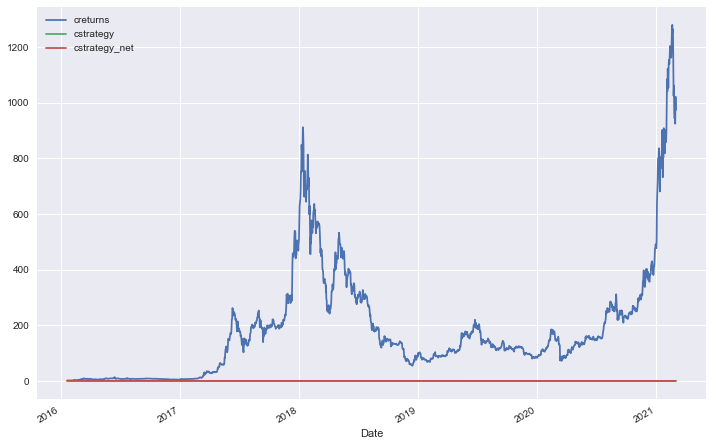

In [48]:
data[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12 , 8))
plt.show()

In [49]:
data[["returns", "strategy_net"]].mean() * (4 * 365) # annualized return

returns         5.390270
strategy_net   -5.696501
dtype: float64

In [50]:
data[["returns", "strategy_net"]].std() * np.sqrt(4 * 365) # annualized risk

returns         2.275077
strategy_net    1.911981
dtype: float64

## Using the BBBacktester Class

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [52]:
class BBBacktester():
    ''' Class for the vectorized backtesting of Mean Reversion-based trading strategies (Bollinger Bands).

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA: int
        time window for SMA
    dev: int
        distance for Lower/Upper Bands in Standard Deviation units
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new parameters for SMA and dev
        
    test_strategy:
        runs the backtest for the Mean Reversion-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two parameters
    '''
    
    def __init__(self, symbol, SMA, dev, start, end, tc):
        self.symbol = symbol
        self.SMA = SMA
        self.dev = dev
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        
    def __repr__(self):
        rep = "BBBacktester(symbol = {}, SMA = {}, dev = {}, start = {}, end = {})"
        return rep.format(self.symbol, self.SMA, self.dev, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("ETH_close.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "Close"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA"] = raw["Close"].rolling(self.SMA).mean()
        raw["Lower"] = raw["SMA"] - raw["Close"].rolling(self.SMA).std() * self.dev
        raw["Upper"] = raw["SMA"] + raw["Close"].rolling(self.SMA).std() * self.dev
        self.data = raw
        return raw
        
    def set_parameters(self, SMA = None, dev = None):
        ''' Updates parameters and resp. time series.
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["Close"].rolling(self.SMA).mean()
            self.data["Lower"] = self.data["SMA"] - self.data["Close"].rolling(self.SMA).std() * self.dev
            self.data["Upper"] = self.data["SMA"] + self.data["Close"].rolling(self.SMA).std() * self.dev
            
        if dev is not None:
            self.dev = dev
            self.data["Lower"] = self.data["SMA"] - self.data["Close"].rolling(self.SMA).std() * self.dev
            self.data["Upper"] = self.data["SMA"] + self.data["Close"].rolling(self.SMA).std() * self.dev
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["distance"] = data.Close - data.SMA
        data["position"] = np.where(data.Close < data.Lower, 1, np.nan)
        data["position"] = np.where(data.Close > data.Upper, -1, data["position"])
        data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data["position"])
        data["position"] = data.position.ffill().fillna(0)
        data["strategy"] = data.position.shift(1) * data["returns"]
        data.dropna(inplace = True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()

        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
       
        # absolute performance of the strategy
        perf = data["cstrategy"].iloc[-1]
        # out-/underperformance of strategy
        outperf = perf - data["creturns"].iloc[-1]
        
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA = {} | dev = {} | TC = {}".format(self.symbol, self.SMA, self.dev, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, boll):
        ''' Updates parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        Params: tuple
            parameter tuple with SMA and dist
        '''
        self.set_parameters(int(boll[0]), int(boll[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA_range, dev_range):
        ''' Finds global maximum given the parameter ranges.

        Parameters
        ==========
        SMA_range, dist_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA_range, dev_range), finish=None)
        return opt, -self.update_and_run(opt)


In [53]:
tester = BBBacktester("Close", 20, 2, "2016-01-01", "2020-12-31", 0)

In [54]:
tester

BBBacktester(symbol = Close, SMA = 20, dev = 2, start = 2016-01-01, end = 2020-12-31)

In [55]:
tester.test_strategy()

(0.001237,
 -481.650248,
 0.0    1691
 1.0     112
 Name: trades, dtype: int64)

In [56]:
tester.results

,Close,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,
2016-01-21,1.553570,0.014099,1.141784,0.732249,1.551319,0.411786,-1.0,-0.014099,0.0,1.014199,0.986000
2016-01-22,1.501270,-0.034244,1.169991,0.742490,1.597492,0.331279,-1.0,0.034244,0.0,0.980056,1.020349
2016-01-23,1.972670,0.273076,1.220030,0.672677,1.767382,0.752640,-1.0,-0.273076,0.0,1.287795,0.776521
2016-01-24,2.141200,0.081979,1.279366,0.609614,1.949118,0.861834,-1.0,-0.081979,0.0,1.397814,0.715403
2016-01-25,2.499270,0.154632,1.356820,0.511958,2.201683,1.142450,-1.0,-0.154632,0.0,1.631569,0.612907
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,682.642334,0.071031,609.185712,531.481513,686.889910,73.456622,0.0,0.000000,0.0,445.641334,0.001250
2020-12-28,730.397339,0.067618,617.964191,527.495860,708.432521,112.433148,-1.0,0.000000,1.0,476.816670,0.001250
2020-12-29,731.520142,0.001536,625.866241,524.773632,726.958851,105.653900,-1.0,-0.001536,0.0,477.549656,0.001248


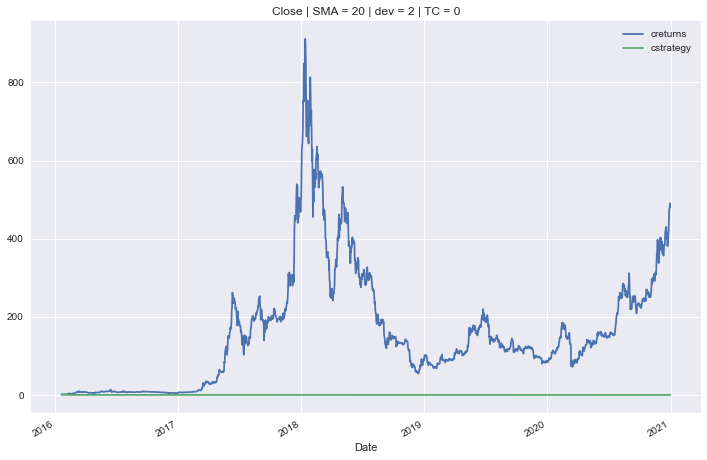

In [57]:
tester.plot_results()

In [58]:
tester.optimize_parameters((9, 100, 1), (1, 10, 1))

(array([26.,  4.]), 1.06152)

In [59]:
tester.test_strategy()

(1.06152,
 -323.052482,
 0.0    1795
 1.0       2
 Name: trades, dtype: int64)

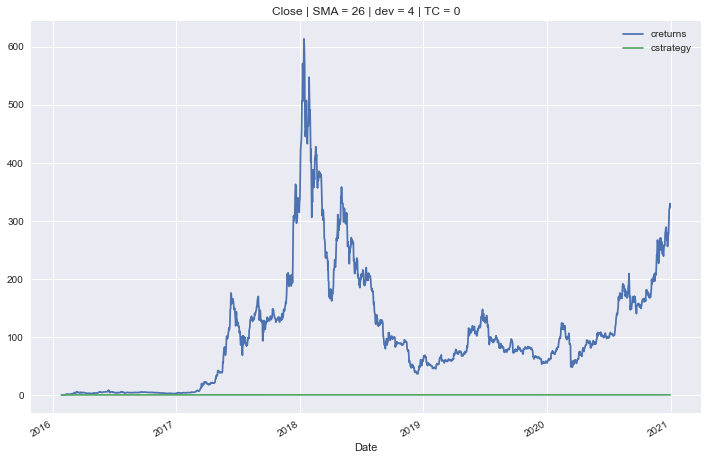

In [60]:
tester.plot_results()

In [61]:
tester.results

,Close,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,
2016-01-27,2.388550,0.048104,1.369808,-0.581226,3.320842,1.018742,0.0,0.0,0.0,1.049280,1.00000
2016-01-28,2.526490,0.056144,1.430938,-0.685852,3.547727,1.095552,0.0,0.0,0.0,1.109877,1.00000
2016-01-29,2.494960,-0.012558,1.489517,-0.749549,3.728582,1.005443,0.0,-0.0,0.0,1.096026,1.00000
2016-01-30,2.445060,-0.020203,1.546847,-0.768294,3.861987,0.898213,0.0,-0.0,0.0,1.074105,1.00000
2016-01-31,2.306040,-0.058538,1.598995,-0.736739,3.934729,0.707045,0.0,-0.0,0.0,1.013034,1.00000
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,682.642334,0.071031,606.095283,465.913375,746.277191,76.547051,0.0,0.0,0.0,299.881970,1.06152
2020-12-28,730.397339,0.067618,611.173936,440.668665,781.679207,119.223403,0.0,0.0,0.0,320.860547,1.06152
2020-12-29,731.520142,0.001536,615.589759,420.660993,810.518525,115.930382,0.0,0.0,0.0,321.353790,1.06152
